# Coronavirus Prediction

## Overview

This project predicts related rates with deep learning methods.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

#import geopandas as gpd

In [3]:
%%capture
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
tqdm().pandas()

# Data Collection

## Coronavirus API

https://www.programmableweb.com/api/coronavirus-tracker-rest-api-v20

In [2]:
url = 'https://coronavirus-tracker-api.herokuapp.com/v2/locations'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            #'source': 'csbs',
            #'country_code': 'US',           
            'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

In [15]:
d['locations'][248]

{'id': 248,
 'country': 'Turkey',
 'country_code': 'TR',
 'country_population': 82319724,
 'province': '',
 'last_updated': '2021-01-27T15:00:34.609843Z',
 'coordinates': {'latitude': '38.9637', 'longitude': '35.2433'},
 'latest': {'confirmed': 2442350, 'deaths': 25344, 'recovered': 0}}

In [3]:
ts = pd.DataFrame(d['locations'][248]['timelines']['deaths'])

In [4]:
ts.index = pd.to_datetime(ts.index).date

<AxesSubplot:>

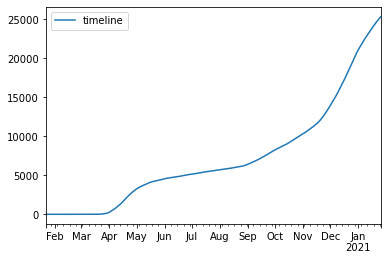

In [35]:
ts.plot()

<AxesSubplot:>

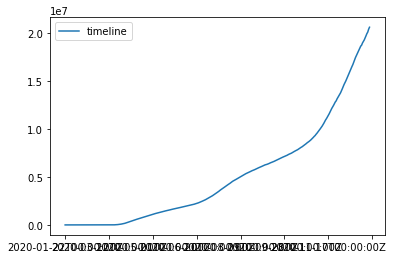

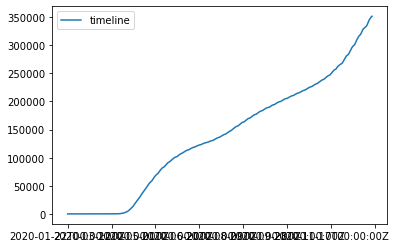

In [54]:
pd.DataFrame(d['locations'][248]['timelines']['confirmed']).plot()
pd.DataFrame(d['locations'][248]['timelines']['deaths']).plot()

In [74]:
df = pd.DataFrame(d['locations'])

In [75]:
df

,id,country,country_code,country_population,province,county,last_updated,coordinates,latest
0,0,US,US,327167434,California,Los Angeles,2021-01-04T13:31:00Z,"{'latitude': '34.053490000000004', 'longitude'...","{'confirmed': 818698, 'deaths': 10773, 'recove..."
1,1,US,US,327167434,California,San Bernardino,2021-01-04T13:31:00Z,"{'latitude': '34.10524', 'longitude': '-117.29...","{'confirmed': 195663, 'deaths': 1447, 'recover..."
2,2,US,US,327167434,California,Riverside,2021-01-04T13:31:00Z,"{'latitude': '33.98171', 'longitude': '-117.37...","{'confirmed': 180553, 'deaths': 1985, 'recover..."
3,3,US,US,327167434,California,San Diego,2021-01-04T13:31:00Z,"{'latitude': '32.71568', 'longitude': '-117.16...","{'confirmed': 168020, 'deaths': 1592, 'recover..."
4,4,US,US,327167434,California,Orange,2021-01-04T13:31:00Z,"{'latitude': '33.78787', 'longitude': '-117.85...","{'confirmed': 161589, 'deaths': 1901, 'recover..."
...,...,...,...,...,...,...,...,...,...
3151,3151,US,US,327167434,US Virgin Islands,St. Thomas,2021-01-04T13:31:00Z,"{'latitude': '18.34899', 'longitude': '-64.930...","{'confirmed': 1028, 'deaths': 0, 'recovered': 0}"
3152,3152,US,US,327167434,US Virgin Islands,St. Croix,2021-01-04T13:31:00Z,"{'latitude': '17.73563', 'longitude': '-64.747...","{'confirmed': 829, 'deaths': 0, 'recovered': 0}"
3153,3153,US,US,327167434,US Virgin Islands,St. John,2021-01-04T13:31:00Z,"{'latitude': '18.33870409', 'longitude': '-64....","{'confirmed': 174, 'deaths': 0, 'recovered': 0}"
3154,3154,US,US,327167434,Northern Mariana Islands,Northern Mariana Islands,2021-01-04T13:31:00Z,"{'latitude': '15.188824770000052', 'longitude'...","{'confirmed': 31, 'deaths': 2, 'recovered': 0}"


## API

https://covidtracking.com/data/api

In [194]:
url = 'https://api.covidtracking.com/v1/us/daily.json'

response = requests.get(url)
d = response.json()

In [195]:
pd.DataFrame(d)

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20210104,56,20560549.0,198034096.0,9463.0,128210.0,699971.0,23435.0,37586.0,7930.0,...,256914140,2021-01-04T24:00:00Z,0,0,1545,4029,1257838,177669,1638082,9a5d7bba3805b8932e540b0cfbc0ce782ef9b94c
1,20210103,56,20382880.0,196776258.0,9407.0,125562.0,695942.0,23243.0,37433.0,7939.0,...,255276058,2021-01-03T24:00:00Z,0,0,1461,2226,1001197,207726,1444369,fd495d4591df97f8297b69a93a38209da53a5d30
2,20210102,56,20175154.0,195775061.0,9356.0,123614.0,693716.0,23133.0,37309.0,7910.0,...,253831689,2021-01-02T24:00:00Z,0,0,2395,3051,1358739,278680,2077336,0a41916c227cf908081548d26fcad961a5f00397
3,20210101,56,19896474.0,194416322.0,11506.0,125047.0,690665.0,23255.0,37196.0,7990.0,...,251754353,2021-01-01T24:00:00Z,0,0,2596,4507,872785,179852,1276261,7641ed39d70f7ed6a52a1068b5c36f6c91c8d190
4,20201231,56,19716622.0,193543537.0,14931.0,125379.0,686158.0,23099.0,37066.0,8003.0,...,250478092,2020-12-31T24:00:00Z,0,0,3287,4290,1120447,223036,1748878,87a8179b8e103555fec80788c35221afd086662a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,20200117,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-17T24:00:00Z,0,0,0,0,0,0,0,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6
354,20200116,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-16T24:00:00Z,0,0,0,0,0,0,0,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
355,20200115,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-15T24:00:00Z,0,0,0,0,0,0,0,8a449023413eea473277416e9e30ae126c6af047
356,20200114,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-14T24:00:00Z,0,0,0,0,0,0,0,fe399466a3dfbe0221a18ed5cacb39a3882d72f8


In [196]:
url = 'https://api.covidtracking.com/v1/us/current.json'

response = requests.get(url)
d = response.json()

In [197]:
d

[{'date': 20210104,
  'states': 56,
  'positive': 20560549,
  'negative': 198034096,
  'pending': 9463,
  'hospitalizedCurrently': 128210,
  'hospitalizedCumulative': 699971,
  'inIcuCurrently': 23435,
  'inIcuCumulative': 37586,
  'onVentilatorCurrently': 7930,
  'onVentilatorCumulative': 3692,
  'recovered': 8299717,
  'dateChecked': '2021-01-04T24:00:00Z',
  'death': 344808,
  'hospitalized': 699971,
  'totalTestResults': 256914140,
  'lastModified': '2021-01-04T24:00:00Z',
  'total': 0,
  'posNeg': 0,
  'deathIncrease': 1545,
  'hospitalizedIncrease': 4029,
  'negativeIncrease': 1257838,
  'positiveIncrease': 177669,
  'totalTestResultsIncrease': 1638082,
  'hash': '9a5d7bba3805b8932e540b0cfbc0ce782ef9b94c'}]

In [202]:
#url = 'https://api.covidtracking.com/v1/us/20200501.json'
url = 'https://api.covidtracking.com/v1/states/daily.json'

response = requests.get(url)
d = response.json()

In [204]:
pd.DataFrame(d)

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210104,AK,46812.0,NaN,1250686.0,NaN,totalTestsViral,1297498.0,97.0,1033.0,...,1297498,3,0,38c46f0e7665bfa2a088389162ae643ab0f7c47b,0,0,0,0,0,
1,20210104,AL,374095.0,72609.0,1601902.0,NaN,totalTestsPeopleViral,1903388.0,3064.0,35430.0,...,1975997,5,1057,3a5911f450cc081cc151cac160ab040d8b156402,0,0,0,0,0,
2,20210104,AR,234781.0,41126.0,1901966.0,NaN,totalTestsViral,2095621.0,1296.0,11514.0,...,2136747,51,0,c68de0e9a5cf79ae4a90e113ba1f80a7484916e7,0,0,0,0,0,
3,20210104,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,...,2140,0,0,ab3d7aae8a16bba4952e91bfe530f31564a0ee9e,0,0,0,0,0,
4,20210104,AZ,561542.0,28267.0,2404314.0,NaN,totalTestsViral,5288658.0,4647.0,39897.0,...,2965856,3,169,a68db19ed7c33ed6c1b432cc88bea654e40710b6,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17262,20200117,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,effcc7b17054638471dec2f2a9cdbd3229d92042,0,0,0,0,0,
17263,20200116,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,d9453d58f00994cff1f81639e95e532d1dd10138,0,0,0,0,0,
17264,20200115,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,bd1eef4afdffd883e37be1d3f321dc3b0e75f591,0,0,0,0,0,
17265,20200114,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,84aeea9c6a284b151fdb42a863db3c0aadb651bf,0,0,0,0,0,


In [209]:
df = pd.read_excel('default of credit card clients.xls',  index_col=0, header=1)

In [214]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [215]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


## API

https://cord19.vespa.ai

## Zip API

https://www.programmableweb.com/api/zip-api-us

In [133]:
from requests.auth import HTTPBasicAuth

In [ ]:
f = open('api.json')
api_key = json.load(f)

In [164]:
url = f"https://service.zipapi.us/hospital/radius/11367?X-API-KEY={api_key['zip_api']['api']}"

params = {  
            'radius': 20
          }

response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
d = response.json()

In [169]:
pd.DataFrame(d['data'])

,Zip,Name,Address,City,State,telephone,latitude,longitude,website,beds,naics_desc,helipad,population,county,distance
0,11355,NEW YORK HOSPITAL QUEENS,56 45 MAIN ST,FLUSHING,NY,(718) 670-2000,40.7467722760001,-73.8254163829999,http://www.nyhq.org/,519,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,519,QUEENS,1.2056043406980474
1,11375,FOREST HILLS HOSPITAL,102-01 66 ROAD,FOREST HILLS,NY,(516) 562-4060,40.7289946700001,-73.8515067069999,https://www.northwell.edu/find-care/locations/...,222,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,222,QUEENS,1.2667295458905368
2,11432,QUEENS HOSPITAL CENTER,82-68 164TH ST,JAMAICA,NY,(718) 883-2350,40.7170722130001,-73.804556192,http://www.nyc.gov/html/hhc/qhc/html/home/home...,247,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,247,QUEENS,1.464323443176699
3,11355,FLUSHING HOSPITAL MEDICAL CENTER,45 TH AVE & PARSONS BLVD,FLUSHING,NY,(718) 670-5918,40.7554099230001,-73.816465518,http://www.flushinghospital.org,293,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,293,QUEENS,1.8859069570899702
4,11414,JAMAICA HOSPITAL MEDICAL CENTER,8900 VAN WYCK EXPRESSWAY,JAMAICA,NY,(718) 206-6000,40.700103647,-73.816114892,http://jamaicahospital.org/,408,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,408,QUEENS,2.1063832945759255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,07107,COLUMBUS HOSPITAL,495 NORTH 13TH STREET,NEWARK,NJ,(973) 587-7712,40.772604012,-74.1867090869999,http://www.columbusltach.org,63,SPECIALTY (EXCEPT PSYCHIATRIC AND SUBSTANCE AB...,N,63,ESSEX,19.046704035393592
118,07103,THE UNIVERSITY HOSPITAL,150 BERGEN STREET,NEWARK,NJ,(973) 972-5658,40.740603133,-74.191061732,http://www.uhnj.org/,519,GENERAL MEDICAL AND SURGICAL HOSPITALS,Y,519,ESSEX,19.05932172210713
119,10522,ST. JOHN'S RIVERSIDE HOSPITAL - DOBBS FERRY,128 ASHFORD AVE,DOBBS FERRY,NY,(914) 693-0700,41.014392248,-73.861919649,http://www.riversidehealth.org,12,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,12,WESTCHESTER,19.775034789331748
120,07652,BERGEN REGIONAL MEDICAL CENTER,230 EAST RIDGEWOOD AVENUE,PARAMUS,NJ,(201) 967-4000,40.956667775,-74.0629917159999,http://www.bergenregional.com,510,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,510,BERGEN,19.95883250040654


In [181]:
url = f"https://service.zipapi.us/age/zipcode/11367?X-API-KEY={api_key['zip_api']['api']}"

# params = {  
#             'fields': ['male_age','female_age']
#           }

response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
d = response.json()

In [182]:
d

{'status': True,
 'data': {'median_age': '34.2', 'male_age': '32.1', 'female_age': '36.3'}}

## Web Scraping

# Modeling

## ARIMA

In [113]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
url = 'https://api.covidtracking.com/v1/us/daily.json'
response = requests.get(url)
d = response.json()
df = pd.DataFrame(d)
df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
df.set_index('date', inplace=True)

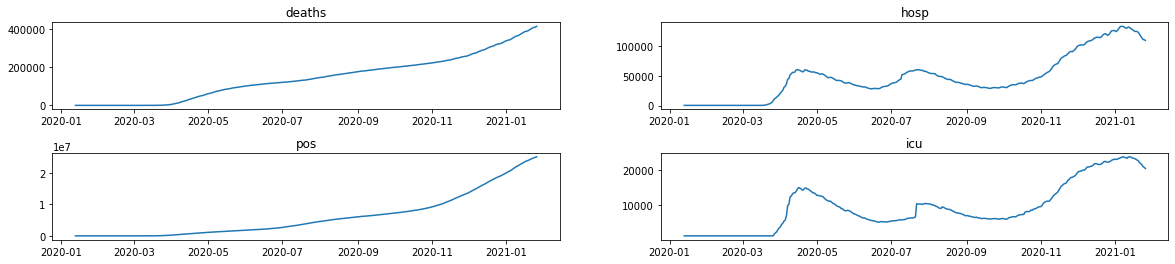

In [24]:
deaths = pd.DataFrame(df.death, index=df.index)
pos = pd.DataFrame(df.positive, index=df.index)
hosp = pd.DataFrame(df.hospitalizedCurrently, index=df.index)
icu = pd.DataFrame(df.inIcuCurrently, index=df.index)

deaths.ffill(inplace=True)
pos.ffill(inplace=True)
hosp.ffill(inplace=True)
icu.ffill(inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(20,4))
axs[0, 0].plot(deaths)
axs[0, 0].set_title('deaths')
axs[1, 0].plot(pos)
axs[1, 0].set_title('pos')
axs[0, 1].plot(hosp)
axs[0, 1].set_title('hosp')
axs[1, 1].plot(icu)
axs[1, 1].set_title('icu')
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [39]:
# deaths_weekly = deaths.resample('W')
# pos_weekly = pos.resample('W')
# hosp_weekly = hosp.resample('W')
# icu_weekly = icu.resample('W')

# deaths_weekly_mean = deaths_weekly.mean()
# pos_weekly_mean = pos_weekly.mean()
# hosp_weekly_mean = hosp_weekly.mean()
# icu_weekly_mean = icu_weekly.mean()

# fig, axs = plt.subplots(2, 2, figsize=(20,4))
# axs[0, 0].plot(deaths_weekly_mean)
# axs[0, 0].set_title('deaths_weekly_mean')
# axs[1, 0].plot(pos_weekly_mean)
# axs[1, 0].set_title('pos_weekly_mean')
# axs[0, 1].plot(hosp_weekly_mean)
# axs[0, 1].set_title('hosp_weekly_mean')
# axs[1, 1].plot(icu_weekly_mean)
# axs[1, 1].set_title('icu_weekly_mean')
# plt.subplots_adjust(hspace = 0.5)
# plt.show()

In [132]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(data_minus_exp_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -2.380662
p-value                          0.147269
#Lags Used                      15.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


In [85]:
# Determine rolling statistics
roll_mean = deaths.rolling(window=3).mean()
roll_std = deaths.rolling(window=3).std()

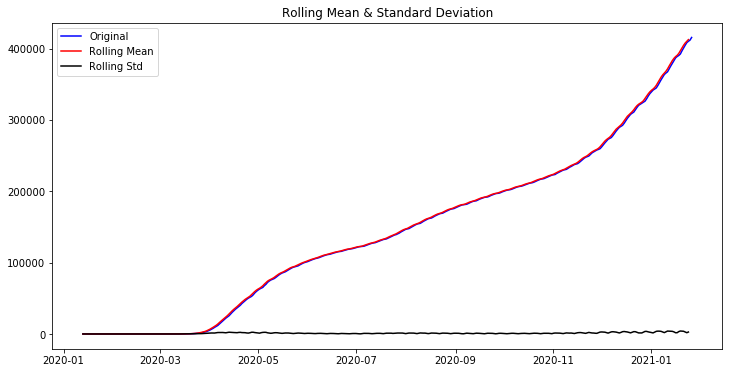

In [86]:
# Plot rolling statistics
fig = plt.figure(figsize=(12,6))
plt.plot(deaths, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [104]:
# Subtract the moving average from the log transformed data
data_minus_roll_mean = deaths - roll_mean

# Print the first 10 rows
data_minus_roll_mean.head(10)

,death
date,
2021-01-26,NaN
2021-01-25,NaN
2021-01-24,-2306.666667
2021-01-23,-1827.000000
2021-01-22,-3042.000000
2021-01-21,-3850.333333
2021-01-20,-3912.000000
2021-01-19,-4232.000000
2021-01-18,-2897.000000


In [122]:
# Drop the missing values
data_minus_roll_mean.dropna(inplace=True)

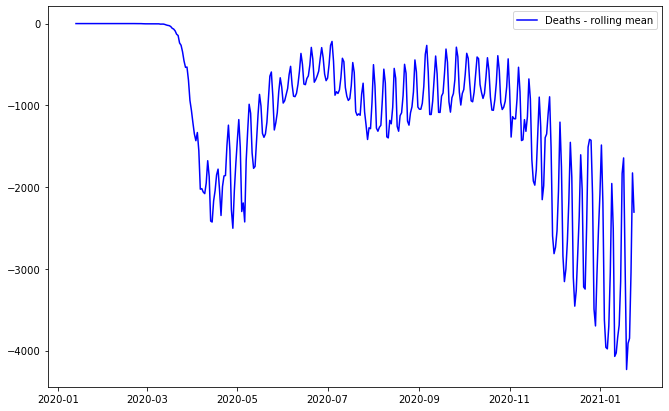

In [105]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Deaths - rolling mean')
plt.legend(loc='best')
plt.show(block=False)

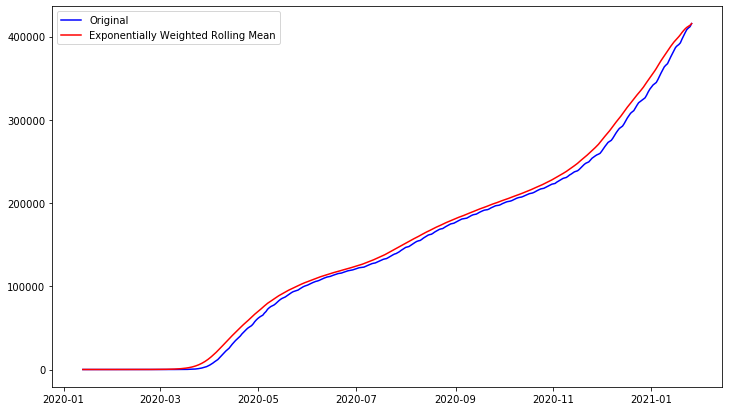

In [109]:
# Calculate Weighted Moving Average of log transformed data
exp_roll_mean = deaths.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(deaths, color='blue',label='Original')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

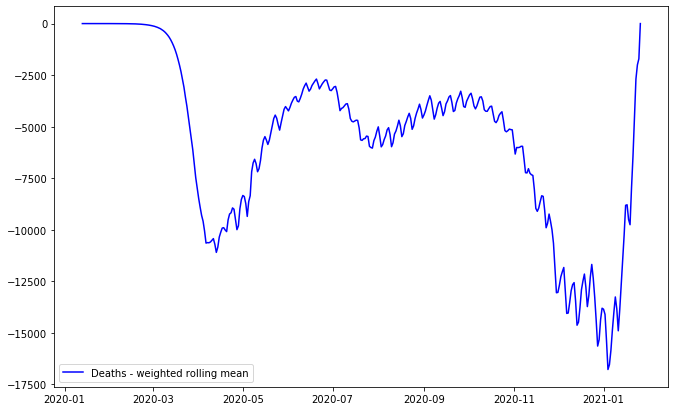

In [110]:
# Subtract the moving average from the original data and check head for Nans
data_minus_exp_roll_mean = deaths - exp_roll_mean

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Deaths - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


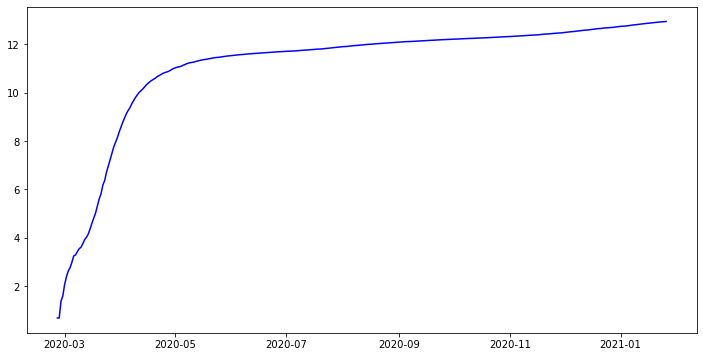

In [127]:
# Plot a log transform
deaths_log = np.log(deaths)
fig = plt.figure(figsize=(12,6))
plt.plot(deaths_log, color='blue');

In [111]:
# Difference your data
data_diff = data_minus_exp_roll_mean.diff(periods=1)

# Drop the missing values
data_diff.dropna(inplace=True)

# Check out the first few rows
data_diff.head(15)

,death
date,
2021-01-25,-1705.640355
2021-01-24,-298.401799
2021-01-23,-687.704681
2021-01-22,-1866.205846
2021-01-21,-1878.637168
2021-01-20,-1542.590331
2021-01-19,-1780.994833
2021-01-18,256.540386
2021-01-17,711.368744


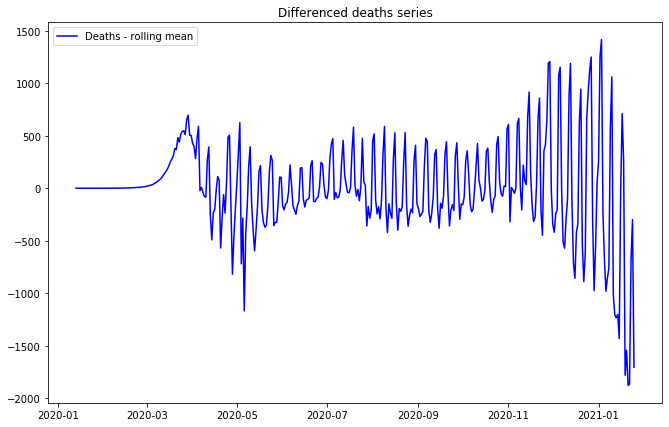

In [112]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Deaths - rolling mean')
plt.legend(loc='best')
plt.title('Differenced deaths series')
plt.show(block=False)

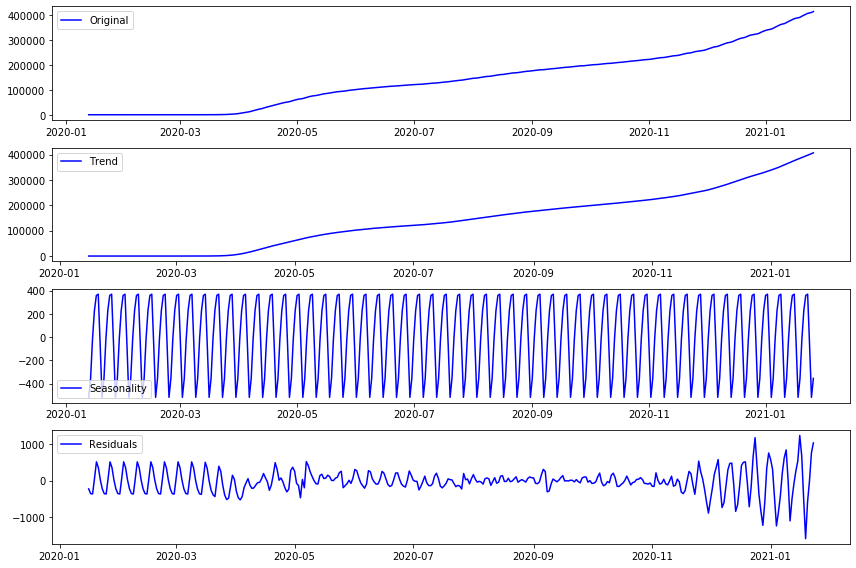

In [115]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(deaths)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(deaths, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

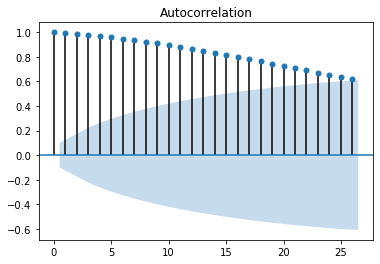

In [133]:
#plot autocorrelation for each lag (alpha is confidence interval)
plot_acf(hosp, alpha=.05);

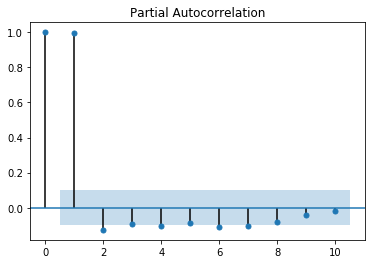

In [134]:
plot_pacf(hosp, alpha=.05, lags=10);

In [101]:
# Fit an ARMA(1,0) model
mod_arma = ARMA(deaths, order=(1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                  death   No. Observations:                  380
Model:                     ARMA(1, 0)   Log Likelihood               -3314.661
Method:                       css-mle   S.D. of innovations           1464.916
Date:                Wed, 27 Jan 2021   AIC                           6635.321
Time:                        09:57:21   BIC                           6647.142
Sample:                             0   HQIC                          6640.012
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.606e+04        nan        nan        nan         nan         nan
ar.L1.death     1.0000        nan        nan        nan         nan         nan
                                    Roots       

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [186]:
residual.dropna(inplace=True)

In [187]:
model = ARIMA(residual, order=(5,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.resid   No. Observations:                  372
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -2423.207
Method:                       css-mle   S.D. of innovations            160.154
Date:                Wed, 27 Jan 2021   AIC                           4864.415
Time:                        16:27:15   BIC                           4899.685
Sample:                             2   HQIC                          4878.422
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0021      0.019      0.111      0.912      -0.035       0.039
ar.L1.D2.resid     0.2115      0.068      3.095      0.002       0.078       0.345
ar.L2.D2.resid    -0.5479      0.044

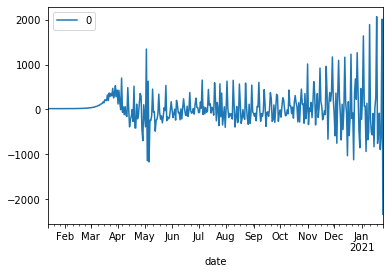

In [70]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

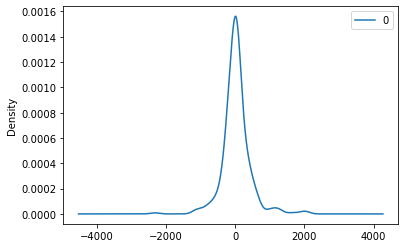

In [71]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
plt.show()

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


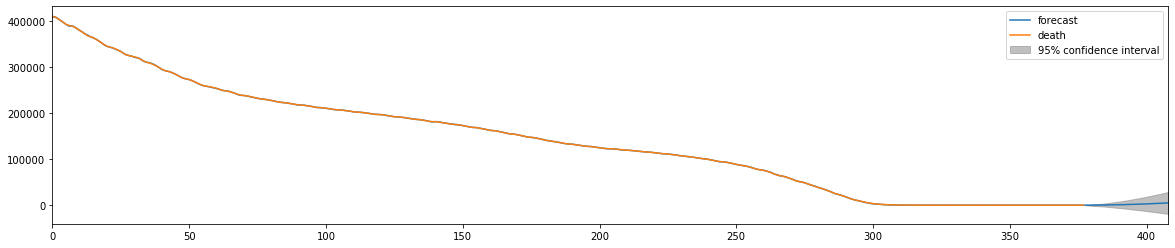

In [182]:
fig, ax = plt.subplots(figsize=(20,4))
model_fit.plot_predict(start=2, end=410, ax=ax);
plt.show()

In [141]:
#forecasting the next periods
model_fit.forecast(1)

(array([20.30952479]),
 array([242.52359558]),
 array([[-455.02798794,  495.64703752]]))

## Prophet

In [5]:
from fbprophet import Prophet

In [26]:
ts.index.name = 'ds'
ts = ts.reset_index()
ts = ts.rename(columns={'timeline': 'y'})

In [27]:
Model = Prophet(interval_width=0.95)
Model.fit(ts)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future_dates = Model.make_future_dataframe(periods=30, freq='D')
future_dates.tail()

,ds
396,2021-02-21
397,2021-02-22
398,2021-02-23
399,2021-02-24
400,2021-02-25


In [29]:
forecast = Model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-9.257413,-364.547889,352.641914,-9.257413,-9.257413,3.252063,3.252063,3.252063,3.252063,3.252063,3.252063,0.0,0.0,0.0,-6.005350
1,2020-01-23,-9.051921,-330.679996,348.737192,-9.051921,-9.051921,5.321936,5.321936,5.321936,5.321936,5.321936,5.321936,0.0,0.0,0.0,-3.729985
2,2020-01-24,-8.846429,-338.003886,329.736907,-8.846429,-8.846429,3.620696,3.620696,3.620696,3.620696,3.620696,3.620696,0.0,0.0,0.0,-5.225733
3,2020-01-25,-8.640936,-348.355099,331.868003,-8.640936,-8.640936,0.646546,0.646546,0.646546,0.646546,0.646546,0.646546,0.0,0.0,0.0,-7.994390
4,2020-01-26,-8.435444,-346.592119,311.619874,-8.435444,-8.435444,-2.546229,-2.546229,-2.546229,-2.546229,-2.546229,-2.546229,0.0,0.0,0.0,-10.981673


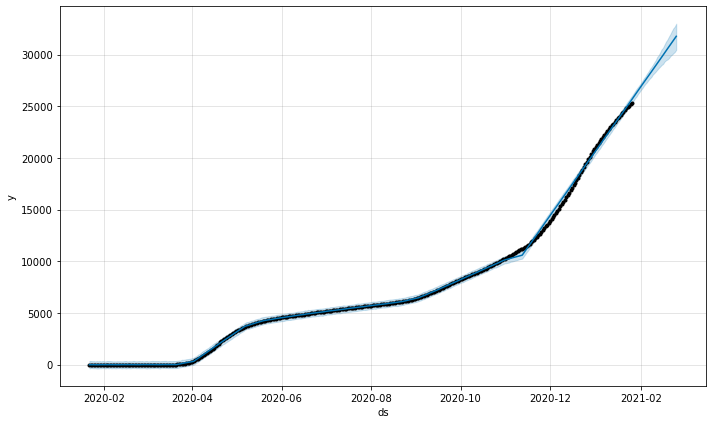

In [30]:
Model.plot(forecast, uncertainty=True)
plt.show()

## LSTM

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [39]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [85]:
df = pd.DataFrame()
df['death'] = ts['y']

In [86]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [87]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train.shape, test.shape

((248, 1), (123, 1))

In [88]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [89]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [90]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=-1)

In [91]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2077.73 RMSE
Test Score: 10200.75 RMSE


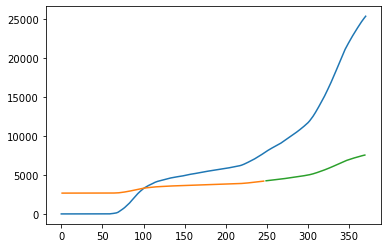

In [93]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Conclusion